In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

# DATA PREPROCESSING

In [2]:
def normalize(_V):
    return (_V - np.min(_V)) / (np.max(_V) - np.min(_V))

def normalize_joystick_readings(x, y):
    x_magnitude = normalize(x)
    y_magnitude = normalize(y)
    return x_magnitude, y_magnitude


In [3]:
def load_jstick_data():
    # Load and preprocess data
    fname = './data/joystick_track.npz'
    alldat = np.load(fname, allow_pickle=True)['dat']
    dat = alldat[0]
    patient_idx = 1
    d = dat[patient_idx]
    # ecog
    ecog_data = d['V'] # Add batch and sequence length dimensions
    # magnitudes
    targetX = d['targetX']
    targetY = d['targetY']
    x_magnitude, y_magnitude = normalize_joystick_readings(targetX, targetY)
    magnitudes = np.stack((x_magnitude, y_magnitude), axis=1)
    
    return ecog_data, magnitudes
    

train test split

In [4]:

# train test
def train_test_split(ecog_data, magnitudes, train_size=0.8):
    n_samples = ecog_data.shape[0]
    n_train = int(n_samples * train_size)
    n_test = n_samples - n_train
    train_idx = np.random.choice(n_samples, n_train, replace=False)
    test_idx = np.setdiff1d(np.arange(n_samples), train_idx)
    X_train = ecog_data[train_idx]
    y_train = magnitudes[train_idx]
    X_test = ecog_data[test_idx]
    y_test = magnitudes[test_idx]
    return X_train, y_train, X_test, y_test

X, y = load_jstick_data()

X_train, y_train, X_test, y_test = train_test_split(X, y)


scaler

In [5]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled.shape, y_train.shape, X_test_scaled.shape, y_test.shape)

(198912, 64) (198912, 2, 1) (49728, 64) (49728, 2, 1)


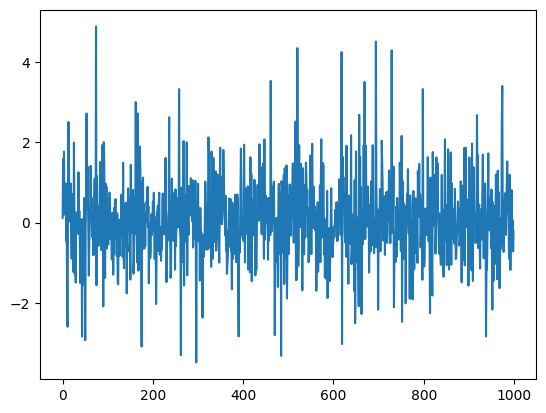

In [6]:
#plot scaled data 
import matplotlib.pyplot as plt

plt.plot(X_train_scaled[:1000, 0])
plt.show()

In [7]:
skip_kurtosis = True

In [8]:
from sklearn.decomposition import FastICA
from scipy.stats import kurtosis
import matplotlib.pyplot as plt

# Fit ICA with different numbers of components
if skip_kurtosis:
    n_components = 54
else:
    kurtosis_values = []
    for n in range(1, X_train_scaled.shape[1] + 1):
        ica = FastICA(n_components=n)
        X_train_ica = ica.fit_transform(X_train_scaled)
        kurtosis_values.append(np.mean(kurtosis(X_train_ica)))

    # Plot kurtosis values
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, X_train_scaled.shape[1] + 1), kurtosis_values)
    plt.xlabel('Number of Components')
    plt.ylabel('Average Kurtosis')
    plt.title('Kurtosis by Number of Components')
    plt.grid(True)
    plt.show()

    # Choose number of components with maximum kurtosis
    n_components = np.argmax(kurtosis_values) + 1
    print(f'Number of components with maximum kurtosis: {n_components}')


artifact removal

In [9]:
from sklearn.decomposition import FastICA
number_of_components = n_components
ica = FastICA(n_components=number_of_components)
X_train_ica = ica.fit_transform(X_train_scaled)
X_test_ica = ica.transform(X_test_scaled)
print(X_train_ica.shape)


c:\Users\thewa\miniconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


(198912, 54)


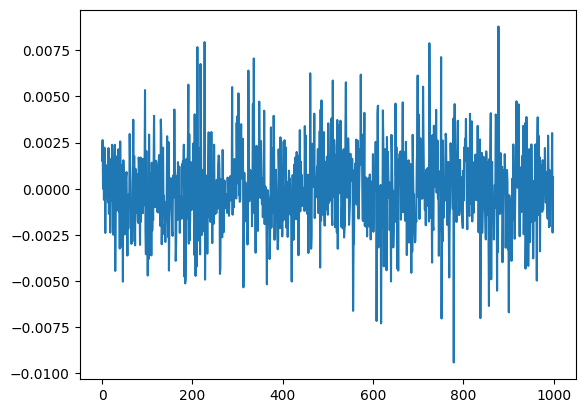

In [10]:
#plot 
plt.plot(X_train_ica[:1000, 0])

DIMENSIONALITY REDUCTION with PCA

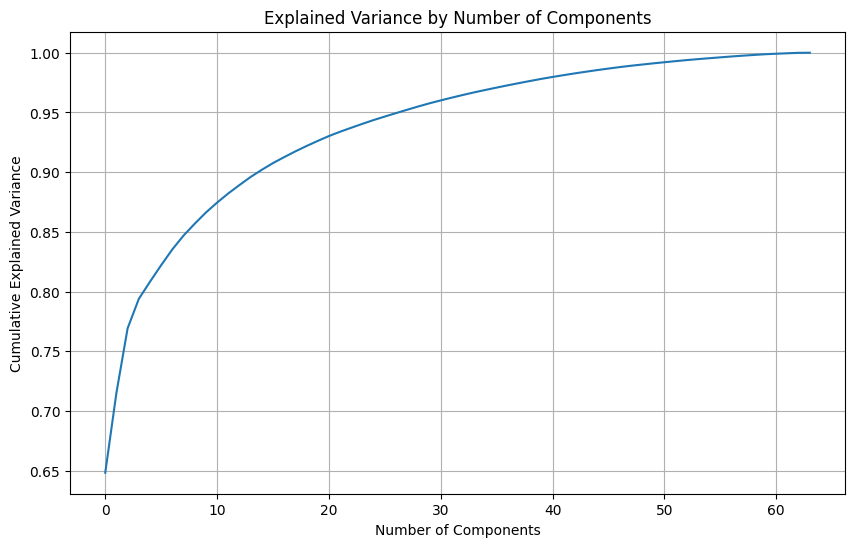

Number of components to retain 95% variance: 28


In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fit PCA
pca = PCA().fit(X_train_scaled)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.grid(True)
plt.show()

# Choose number of components to retain 95% variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f'Number of components to retain 95% variance: {n_components}')


In [12]:
from sklearn.decomposition import PCA
number_of_components = n_components
pca = PCA(n_components=number_of_components)
X_train_pca = pca.fit_transform(X_train_ica)
X_test_pca = pca.transform(X_test_ica)
print(X_train_pca.shape, X_test_pca.shape)


(198912, 28) (49728, 28)


segmentation

In [13]:
def create_sequences(data, chunks):
    sequences = []
    data_len = data.shape[0]
    for i in range(0, data_len - chunks + 1, chunks):
        sequences.append(data[i:i + chunks])
    return np.array(sequences)

chunks = 248 # Example sequence length
X_train_seq = create_sequences(X_train_scaled, chunks)
X_test_seq = create_sequences(X_test_scaled, chunks)
print(X_train_seq.shape, X_test_seq.shape)

(802, 248, 64) (200, 248, 64)


MODELS 😲

In [14]:
# Define the Autoencoder and LSTM models
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=32):
        super(Encoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
        self.rnn1 = nn.LSTM(n_features, self.hidden_dim, batch_first=True)
        self.rnn2 = nn.LSTM(self.hidden_dim, embedding_dim, batch_first=True)

    def forward(self, x):
        x, _ = self.rnn1(x)
        x, (hidden, _) = self.rnn2(x)
        return hidden

class Decoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=32):
        super(Decoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
        self.rnn1 = nn.LSTM(embedding_dim, self.hidden_dim, batch_first=True)
        self.rnn2 = nn.LSTM(self.hidden_dim, n_features, batch_first=True)

    def forward(self, x):
        x = x.repeat(self.seq_len, 1, 1).permute(1, 0, 2)
        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)
        return x

class LSTMAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=32):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim)
        self.decoder = Decoder(seq_len, n_features, embedding_dim)

    def forward(self, x):
        latent = self.encoder(x)
        return self.decoder(latent)

class TemporalLSTM(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(TemporalLSTM, self).__init__()
        self.lstm = nn.LSTM(latent_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x

class CombinedModel(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim, hidden_dim, output_dim):
        super(CombinedModel, self).__init__()
        self.autoencoder = LSTMAutoencoder(seq_len, n_features, embedding_dim)
        self.temporal_lstm = TemporalLSTM(embedding_dim, hidden_dim, output_dim)

    def forward(self, x):
        latent = self.autoencoder.encoder(x)
        prediction = self.temporal_lstm(latent)
        return prediction

new loss


In [15]:
class SmoothTrajectoryLoss(nn.Module):
    def __init__(self, lambda_smooth=0.1):
        super(SmoothTrajectoryLoss, self).__init__()
        self.lambda_smooth = lambda_smooth
        self.mse_loss = nn.MSELoss()

    def forward(self, predicted, target):
        # MSE Loss
        mse_loss = self.mse_loss(predicted, target)
        
        # Smoothness Term
        smoothness_term = torch.mean((predicted[:, 1:] - predicted[:, :-1]) ** 2)
        
        # Total Loss
        total_loss = mse_loss + self.lambda_smooth * smoothness_term
        return total_loss


model init

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hyperparameter tuning

In [17]:
# Define hyperparameters
n_epochs = 500
lr = 1e-3
hidden_dim = 32
# one prediction per chunk
output_dim = 2
seq_length = chunks


In [18]:
# Initialize and train the model
from torch.optim.lr_scheduler import StepLR
model = CombinedModel(X_train_seq[1], X_train_seq.shape[-1], embedding_dim=16, hidden_dim=hidden_dim, output_dim=output_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#scheduler = StepLR(optimizer, step_size=n_epochs//20, gamma=0.1)

training loop!

In [26]:
X_train_seq = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
losses = []
for epoch in range(n_epochs):
    for seq in X_train_seq:
        model.train()
        optimizer.zero_grad()
        prediction = model(seq.unsqueeze(0))
        #print(prediction.shape, y_train_tensor.shape)
        loss = criterion(prediction, y_train_tensor) 
        loss.backward()
        optimizer.step()
        #scheduler.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss {loss.item()}')

C:\Users\thewa\AppData\Local\Temp\ipykernel_24172\2571210840.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_seq = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
c:\Users\thewa\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([198912, 2, 1])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss 0.10619819909334183
Epoch 10, Loss 0.10619819909334183
Epoch 20, Loss 0.10619819909334183
Epoch 30, Loss 0.10619819909334183
Epoch 40, Loss 0.10619819909334183
Epoch 50, Loss 0.10619819909334183
Epoch 60, Loss 0.10619819909334183
Epoch 70, Loss 0.10619819909334183
Epoch 80, Loss 0.10619819909334183
Epoch 90, Loss 0.10619819909334183
Epoch 100, Loss 0.10619819909334183
Epoch 110, Loss 0.10619819909334183
Epoch 120, Loss 0.10619819909334183
Epoch 130, Loss 0.10619819909334183
Epoch 140, Loss 0.10619819909334183
Epoch 150, Loss 0.10619819909334183
Epoch 160, Loss 0.10619819909334183
Epoch 170, Loss 0.10619819909334183
Epoch 180, Loss 0.10619819909334183
Epoch 190, Loss 0.10619819909334183
Epoch 200, Loss 0.10619819909334183
Epoch 210, Loss 0.10619819909334183
Epoch 220, Loss 0.10619819909334183
Epoch 230, Loss 0.10619819909334183
Epoch 240, Loss 0.10619819909334183
Epoch 250, Loss 0.10619819909334183
Epoch 260, Loss 0.10619819909334183
Epoch 270, Loss 0.10619819909334183
Epo

loss is not updating! 😭

plot losses

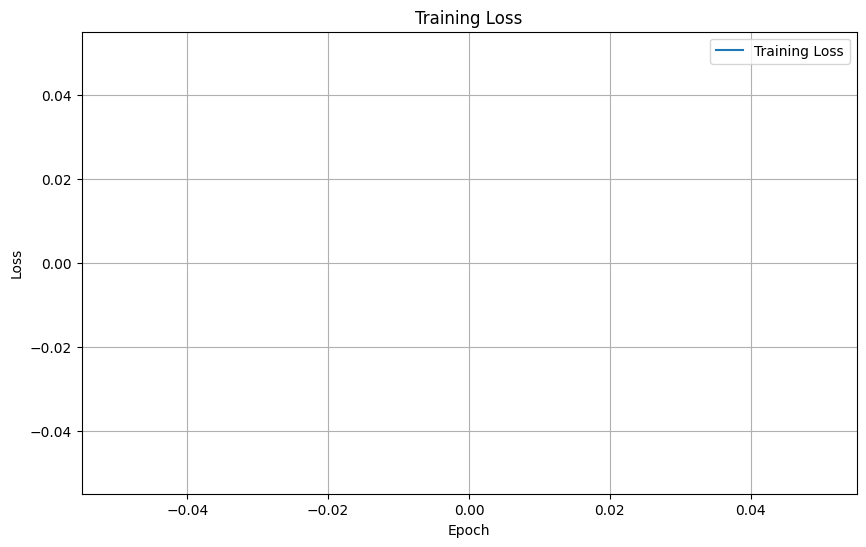

In [ ]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()
plt.show()

[tensor([[-0.0074, -0.0099]], device='cuda:0'), tensor([[0.0222, 0.0018]], device='cuda:0'), tensor([[-0.0010, -0.0031]], device='cuda:0'), tensor([[0.0265, 0.0167]], device='cuda:0'), tensor([[-0.0458, -0.0419]], device='cuda:0'), tensor([[ 0.0018, -0.0048]], device='cuda:0'), tensor([[0.0566, 0.0524]], device='cuda:0'), tensor([[-0.0338, -0.0277]], device='cuda:0'), tensor([[-0.0060, -0.0144]], device='cuda:0'), tensor([[0.0427, 0.0451]], device='cuda:0'), tensor([[0.0515, 0.0431]], device='cuda:0'), tensor([[0.0153, 0.0111]], device='cuda:0'), tensor([[0.0062, 0.0066]], device='cuda:0'), tensor([[-0.0305, -0.0389]], device='cuda:0'), tensor([[0.0456, 0.0403]], device='cuda:0'), tensor([[0.0261, 0.0260]], device='cuda:0'), tensor([[0.0476, 0.0436]], device='cuda:0'), tensor([[-0.0190, -0.0317]], device='cuda:0'), tensor([[-0.0310, -0.0357]], device='cuda:0'), tensor([[ 0.0012, -0.0043]], device='cuda:0'), tensor([[0.0416, 0.0414]], device='cuda:0'), tensor([[0.0564, 0.0528]], device=

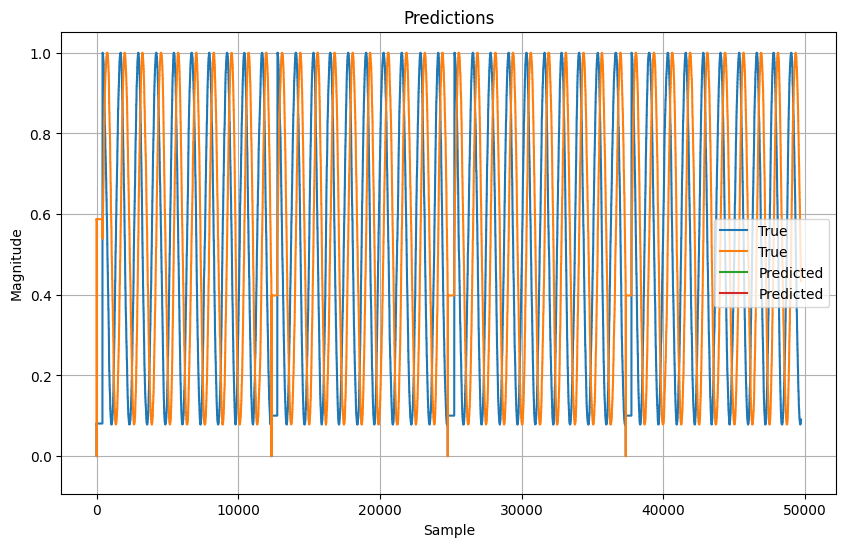

In [ ]:
# eval
model.eval()
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
y_preds = []
with torch.no_grad():
    for batch in X_test_tensor:
        y_pred = model(batch.unsqueeze(0))
        y_preds.append(y_pred)
print(y_preds)
print(X_test_tensor[0].shape, y_test_tensor.shape, y_pred.shape)
#torch.Size([1, 99, 54]) torch.Size([49728, 2, 1]) torch.Size([1, 2])

# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test.squeeze(), label='True')
plt.plot(y_pred.cpu().detach().numpy(), label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Magnitude')
plt.title('Predictions')
plt.grid(True)
plt.legend()